### notebook to clean the afvalcontainers geoJson 

This WFS can be downloaded from https://api.data.amsterdam.nl/api/, will be cleaned and enriched with some data about the districts of Amsterdam (https://api.data.amsterdam.nl/api/swagger/?url=/bag/docs/api-docs/gebieden%3Fformat%3Dopenapi). We then perform a DBSCAN cluster algorythm to cluster the containers into 'inzamellocaties' and load it back into PostgreSQL for further analysis in QGIS/GRASS

In [18]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import json
import pprint
import geopandas as gp
import pandas as pd
pd.set_option('display.max_columns', 100)
import numpy as np
import requests
import ast
from pandas.io.json import json_normalize

In [19]:
# wfs from https://api.data.amsterdam.nl/api/
url = 'https://map.data.amsterdam.nl/maps/afval?REQUEST=GetFeature'
PATH = '/home/diederik/ams/pyprojects/service_afvalcontainers/data/'
fname = 'afvalcontainers.geojson' #from 
fname2 = 'afvalcontainers_kaart_old.geojson' # from https://maps.amsterdam.nl/open_geodata/
csv_file = 'afvalcontainers_kaart_old.csv' 

In [27]:
# load geojson
params = dict(Typename = 'ms:container_coordinaten',
              SERVICE = 'wfs',
              version = '1.1.0',
              outputFormat = 'GeoJson',
              srsname = 'epsg:4326')
response = requests.get(url=url, params=params)
data = response.json()

In [28]:
# parse the json, give nice names
results = []

for item in data['features']:
    result_dict = {}
    
    result_dict['geometry'] = item['geometry']['coordinates']
    result_dict['active'] = item['properties']['active']
    result_dict['buurt_code'] = item['properties']['buurt_code']
    result_dict['container_type_id'] = item['properties']['container_type_id']
    result_dict['container_id'] = item['properties']['id']
    result_dict['id_number'] = item['properties']['id_number']
    result_dict['operate_date'] = item['properties']['operational_date']
    result_dict['owner'] = item['properties']['owner']
    result_dict['place_date'] = item['properties']['placing_date']
    result_dict['serial_number'] = item['properties']['serial_number']
    result_dict['stadsdeel'] = item['properties']['stadsdeel']
    result_dict['address'] = item['properties']['text']
    result_dict['waste_name'] = item['properties']['waste_name']
    result_dict['waste_type'] = item['properties']['waste_type']
    
    results.append(result_dict)

In [29]:
from shapely.geometry import Point
crs = {'init' : 'epsg:4326'}
df = gp.GeoDataFrame(results, crs = crs)
# convert geometry column to Points
df['geometry'] = [Point(xy) for xy in df['geometry']]

### clean up dirty json

In [30]:
def flatten_dict(d):
    '''
    Convert json string representation of dictionary to a python dict
    '''
    return ast.literal_eval(d)

In [31]:
# flatten the 'owner column, merge back on df, drop owner column
owner = json_normalize(df['owner'].apply(flatten_dict).tolist()).add_prefix('owner_')
df = (pd.merge(df, owner, left_index=True, right_index=True)
        .drop(labels=['owner'], axis=1))

In [32]:
# CLEAN UP 
df = df.replace(r'^\s+$', np.nan, regex=True)
# clean year that causes pd.to_datetime to fail
df.loc[df.operate_date.str.split('-', expand=True)[0] == '0201', 'operate_date'] = '2011'

# parse date cols
date_cols = ['operate_date', 'place_date']
for date_col in date_cols:
    df[date_col] = df[date_col].str.partition()[0]
    df[date_col] = pd.to_datetime(df[date_col], format = '%Y-%m-%d')
    
# clean id_number col
unknown_str_cols = ['onbekend', 'unknown', '?', 'geen nr', 'nvt', 'niet bekend', 
                    're onbekend', '', 'pl ....', 'r7-???', 'pl', 'pa', 'tex', 
                    'kff', 'gl', 're 91..', 're', 'pa onbekend', 'pa....']
bovengronds = ['bovengronds rest', 'bovengronds', 'bovengrondse', 'boven']
df['id_number'] = df['id_number'].astype(str).apply(lambda x: x.lower())
df.loc[(df.id_number.isin(unknown_str_cols)), 'id_number'] = np.nan
df.loc[(df.id_number.isin(bovengronds)), 'id_number'] = 'bovengronds'

# clean up waste_name column
na_cols = ['Wat is dit?','Blipvert', 'We weten het niet', 'Wormen', 'Unknown']
df.loc[(df.waste_name.isin(na_cols)), 'waste_name'] = np.nan

# clean up stadsdeel column + waste_type
df['stadsdeel'] = df['stadsdeel'].replace('', np.nan, regex=True)
df['waste_type'] = df['waste_type'].replace('', np.nan, regex=True)
df['waste_type'] = df['waste_type'].astype(str)
# remap active values
active_map = {'t': 'active', 'f': 'non_active'}
df['active'] = df['active'].map(active_map)

# drop a faulty lon coordinate (5006524.0) and treat as outlier 
df['lon'] = df['geometry'].apply(lambda p: p.x).astype(str)
df['lat'] = df['geometry'].apply(lambda p: p.y).astype(str)
df = df.drop(df[df['lon'] == '5006524.0'].index) # 1 row

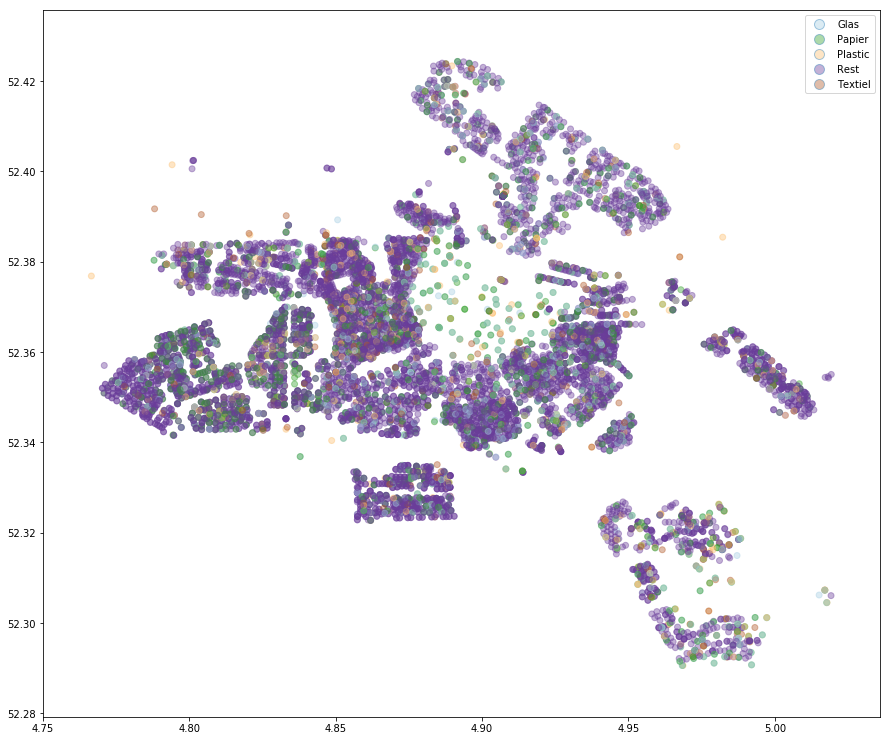

In [33]:
# plot to see map distribution
fig, ax= plt.subplots(figsize=[15,13])
style_kwds = dict(alpha =.4, edgecolor =None)
cmap = plt.cm.Paired
(df.dropna(subset = ['waste_name'], axis=0)
   .query("active == 'active'")
   .plot(column = 'waste_name', ax=ax, legend=True, cmap=cmap, **style_kwds)
)

### Enrich the data with gebieden names

The data contains a ```buurt_code``` . This can be use to call the **Basisregistratie Amsterdamse Gebieden**. The url: https://api.data.amsterdam.nl/gebieden/buurt/. The Swagger documentation shows 

In [35]:
df.head(2)

,active,address,buurt_code,container_id,container_type_id,geometry,id_number,operate_date,place_date,serial_number,stadsdeel,waste_name,waste_type,owner_id,owner_name,lon,lat
0,active,"Eva Besnyöstraat 221, Amsterdam",M51b,18487,495,POINT (5.005727 52.3510657),re 8206,NaT,NaT,BAO01973,M,Rest,1,111,M Oost,5.005727,52.3510657
1,active,"Antonio Vivaldistraat 8, Amsterdam",K23e,90914,3287,POINT (4.8846889 52.3350637),NaN,NaT,NaT,nvt,K,Textiel,7,67,K Zuid,4.8846889,52.3350637


In [36]:
import time
buurt_codes = df['buurt_code'].unique().tolist() # all unique buurt_codes
num_url = 'https://api.data.amsterdam.nl/gebieden/buurt/'

In [38]:
results = []
for bc in buurt_codes:
    print ('loading {}'.format(bc))
    params = {'vollcode': bc}
    response = requests.get(num_url, params)
    
    if response.status_code != 200:
        print (f'Request failed with status code {request.status_code}')
        time.sleep(2)
        continue
    data = response.json()
    
    result = {'vollcode': bc}
    if not data.get('results'):       
        results.append(result)        
        # nothing found.        
        continue        
        
    first_result = data['results'][0]
    
    if not first_result:        
        print('ERROR %s', bc)            
        
    def visdata(*args):        
        """        
        Given arguments get data from nested field        
        like item[arg1][agr2][argx].. but without crashing.        
        """        
        nextvalue = first_result        
        for arg in args[:-1]:            
            nextvalue = nextvalue.get(arg, {})                    
            if not nextvalue:                
                return ''                
                
        return nextvalue.get(args[-1], '')        
    
    # indicate what to extract    
    result['buurt_naam'] = visdata('naam')    
    result['buurt_id'] = visdata('_links', 'self', 'href')
    
    print (result)
    # voeg postcode resultaat toe aan totaal resultaten lijst.    
    results.append(result)    

loading M51b
{'vollcode': 'M51b', 'buurt_naam': 'Haveneiland Oost', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000602/'}
loading K23e
{'vollcode': 'K23e', 'buurt_naam': 'Vivaldi', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630023753996/'}
loading F83a
{'vollcode': 'F83a', 'buurt_naam': 'De Punt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000452/'}
loading K49d
{'vollcode': 'K49d', 'buurt_naam': 'Minervabuurt Noord', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000825/'}
loading F88b
{'vollcode': 'F88b', 'buurt_naam': 'Park Haagseweg', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000478/'}
loading E37g
{'vollcode': 'E37g', 'buurt_naam': 'Landlust Noord', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630023753959/'}
loading K49b
{'vollcode': 'K49b', 'buurt_naam': 'Beethovenbuurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000823/'}
loading K24e
{

{'vollcode': 'M30b', 'buurt_naam': 'Transvaalbuurt Oost', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000756/'}
loading F79b
{'vollcode': 'F79b', 'buurt_naam': 'Buurt 10', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000439/'}
loading M33a
{'vollcode': 'M33a', 'buurt_naam': 'Oostelijke Handelskade', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000581/'}
loading F78d
{'vollcode': 'F78d', 'buurt_naam': 'Buurt 9', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000436/'}
loading F89b
{'vollcode': 'F89b', 'buurt_naam': 'Jacques Veltmanbuurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630023753975/'}
loading E14e
{'vollcode': 'E14e', 'buurt_naam': 'Westerstaatsman', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000554/'}
loading E37d
{'vollcode': 'E37d', 'buurt_naam': 'Landlust Zuid', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000615/'}
loading E40b


{'vollcode': 'K48f', 'buurt_naam': 'Van Tuyllbuurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000821/'}
loading T93f
{'vollcode': 'T93f', 'buurt_naam': 'Hoptille', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000709/'}
loading T96b
{'vollcode': 'T96b', 'buurt_naam': 'Reigersbos Noord', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000733/'}
loading A06d
{'vollcode': 'A06d', 'buurt_naam': 'Marnixbuurt Noord', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000501/'}
loading M55c
{'vollcode': 'M55c', 'buurt_naam': 'Julianapark', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000759/'}
loading M31c
{'vollcode': 'M31c', 'buurt_naam': 'Zuidwestkwadrant Indische buurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000865/'}
loading K54d
{'vollcode': 'K54d', 'buurt_naam': 'Rijnbuurt West', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000840/'}
loadin

{'vollcode': 'N70d', 'buurt_naam': 'Banne Noordoost', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000685/'}
loading K91c
{'vollcode': 'K91c', 'buurt_naam': 'Buitenveldert Zuidoost', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000855/'}
loading F87b
{'vollcode': 'F87b', 'buurt_naam': 'Andreasterrein', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000472/'}
loading F85c
{'vollcode': 'F85c', 'buurt_naam': 'Jacob Geelbuurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000460/'}
loading M33c
{'vollcode': 'M33c', 'buurt_naam': 'Java-eiland', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000583/'}
loading A05a
{'vollcode': 'A05a', 'buurt_naam': 'Westerdokseiland', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000430/'}
loading T94f
{'vollcode': 'T94f', 'buurt_naam': 'K-buurt Midden', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000720/'}
loading N6

{'vollcode': 'T93d', 'buurt_naam': 'F-buurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000495/'}
loading A04g
{'vollcode': 'A04g', 'buurt_naam': 'Valkenburg', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000427/'}
loading M35e
{'vollcode': 'M35e', 'buurt_naam': 'Haveneiland Noordwest', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630023753989/'}
loading E40c
{'vollcode': 'E40c', 'buurt_naam': 'Pieter van der Doesbuurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000625/'}
loading T94a
{'vollcode': 'T94a', 'buurt_naam': 'E-buurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000715/'}
loading M55d
{'vollcode': 'M55d', 'buurt_naam': 'Don Bosco', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000760/'}
loading A09e
{'vollcode': 'A09e', 'buurt_naam': 'Czaar Peterbuurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000523/'}
loading E13a
{'vollcode

{'vollcode': 'E42c', 'buurt_naam': 'Orteliusbuurt Midden', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000636/'}
loading E38c
{'vollcode': 'E38c', 'buurt_naam': 'Erasmusparkbuurt West', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630023753966/'}
loading A06g
{'vollcode': 'A06g', 'buurt_naam': 'Elandsgrachtbuurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000504/'}
loading N65a
{'vollcode': 'N65a', 'buurt_naam': 'Tuindorp Oostzaan West', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000655/'}
loading E39b
{'vollcode': 'E39b', 'buurt_naam': 'Laan van Spartaan', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000620/'}
loading K47f
{'vollcode': 'K47f', 'buurt_naam': 'Hondecoeterbuurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000812/'}
loading N68e
{'vollcode': 'N68e', 'buurt_naam': 'Markengouw Zuid', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/0363000

{'vollcode': 'T93e', 'buurt_naam': 'Amsterdamse Poort', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000496/'}
loading A02c
{'vollcode': 'A02c', 'buurt_naam': 'Felix Meritisbuurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000094/'}
loading K23a
{'vollcode': 'K23a', 'buurt_naam': 'Zuidas Noord', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630023753995/'}
loading N73h
{'vollcode': 'N73h', 'buurt_naam': 'Zunderdorp', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000701/'}
loading K49a
{'vollcode': 'K49a', 'buurt_naam': 'Diepenbrockbuurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000822/'}
loading E75d
{'vollcode': 'E75d', 'buurt_naam': 'Van Brakelkwartier', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630023753965/'}
loading A03d
{'vollcode': 'A03d', 'buurt_naam': 'Amstelveldbuurt', 'buurt_id': 'https://api.data.amsterdam.nl/gebieden/buurt/03630000000100/'}
loading A06

In [39]:
gb = pd.DataFrame(results)
gb['buurt_id'] = gb.buurt_id.str.split('/', expand=True)[5]

In [42]:
### Join dataframes
df_buurt = (pd.merge(df, gb, left_on = ['buurt_code'], right_on=['vollcode'], how='left')
              .drop('vollcode', axis=1))

### add more buurt info to data

```buurt_id``` is great because with this we can get more extensive information calling the same API but with this new buurt_id. We'll extract a whole bunch of new goodies. 

Een bouwblok is het kleinst mogelijk afgrensbare gebied, in zijn geheel tot een buurt behorend, dat geheel of grotendeels door bestaande of aan te leggen wegen en/of waterlopen is of zal zijn ingesloten en waarop tenminste één gebouw staat.

In [43]:
#extract the buurt_id to feed to the API
buurt_ids =  np.unique(df_buurt['buurt_id'].values).tolist()

In [45]:
buurt_list = []

for bc in buurt_ids:
    # build single dict
    result = {}
    
    print ('loading {}'.format(bc))
    url = 'https://api.data.amsterdam.nl/gebieden/buurt/{}/'
    response = requests.get(url.format(bc))
    print (response.url) 
    
    data = response.json()
    
    result['buurt_id'] = bc
    result['buurt_naam'] = data['naam']
    result['stadsdeel_code'] = data['stadsdeel']['code']
    result['stadsdeel_naam'] = data['stadsdeel']['naam']
    result['buurtcombi_naam'] = data['buurtcombinatie']['naam']
    result['buurtcombi_vollcode'] = data['buurtcombinatie']['vollcode']
    result['bouwblokken'] = data['bouwblokken']['count']
    result['ligplaatsen'] = data['ligplaatsen']['count']
    result['standplaatsen'] = data['standplaatsen']['count']
    result['vob_count'] = data['verblijfsobjecten']['count']
    result['bbox'] = data['bbox']
    result['geometrie'] = data['geometrie']
    
    # flow all dicts into buurt_list
    buurt_list.append(result)

loading 03630000000080
https://api.data.amsterdam.nl/gebieden/buurt/03630000000080/
loading 03630000000081
https://api.data.amsterdam.nl/gebieden/buurt/03630000000081/
loading 03630000000084
https://api.data.amsterdam.nl/gebieden/buurt/03630000000084/
loading 03630000000085
https://api.data.amsterdam.nl/gebieden/buurt/03630000000085/
loading 03630000000086
https://api.data.amsterdam.nl/gebieden/buurt/03630000000086/
loading 03630000000088
https://api.data.amsterdam.nl/gebieden/buurt/03630000000088/
loading 03630000000089
https://api.data.amsterdam.nl/gebieden/buurt/03630000000089/
loading 03630000000093
https://api.data.amsterdam.nl/gebieden/buurt/03630000000093/
loading 03630000000094
https://api.data.amsterdam.nl/gebieden/buurt/03630000000094/
loading 03630000000097
https://api.data.amsterdam.nl/gebieden/buurt/03630000000097/
loading 03630000000098
https://api.data.amsterdam.nl/gebieden/buurt/03630000000098/
loading 03630000000099
https://api.data.amsterdam.nl/gebieden/buurt/03630000

https://api.data.amsterdam.nl/gebieden/buurt/03630000000541/
loading 03630000000542
https://api.data.amsterdam.nl/gebieden/buurt/03630000000542/
loading 03630000000543
https://api.data.amsterdam.nl/gebieden/buurt/03630000000543/
loading 03630000000544
https://api.data.amsterdam.nl/gebieden/buurt/03630000000544/
loading 03630000000545
https://api.data.amsterdam.nl/gebieden/buurt/03630000000545/
loading 03630000000546
https://api.data.amsterdam.nl/gebieden/buurt/03630000000546/
loading 03630000000547
https://api.data.amsterdam.nl/gebieden/buurt/03630000000547/
loading 03630000000548
https://api.data.amsterdam.nl/gebieden/buurt/03630000000548/
loading 03630000000549
https://api.data.amsterdam.nl/gebieden/buurt/03630000000549/
loading 03630000000550
https://api.data.amsterdam.nl/gebieden/buurt/03630000000550/
loading 03630000000551
https://api.data.amsterdam.nl/gebieden/buurt/03630000000551/
loading 03630000000552
https://api.data.amsterdam.nl/gebieden/buurt/03630000000552/
loading 0363000

https://api.data.amsterdam.nl/gebieden/buurt/03630000000661/
loading 03630000000662
https://api.data.amsterdam.nl/gebieden/buurt/03630000000662/
loading 03630000000664
https://api.data.amsterdam.nl/gebieden/buurt/03630000000664/
loading 03630000000665
https://api.data.amsterdam.nl/gebieden/buurt/03630000000665/
loading 03630000000666
https://api.data.amsterdam.nl/gebieden/buurt/03630000000666/
loading 03630000000667
https://api.data.amsterdam.nl/gebieden/buurt/03630000000667/
loading 03630000000668
https://api.data.amsterdam.nl/gebieden/buurt/03630000000668/
loading 03630000000669
https://api.data.amsterdam.nl/gebieden/buurt/03630000000669/
loading 03630000000670
https://api.data.amsterdam.nl/gebieden/buurt/03630000000670/
loading 03630000000671
https://api.data.amsterdam.nl/gebieden/buurt/03630000000671/
loading 03630000000673
https://api.data.amsterdam.nl/gebieden/buurt/03630000000673/
loading 03630000000675
https://api.data.amsterdam.nl/gebieden/buurt/03630000000675/
loading 0363000

https://api.data.amsterdam.nl/gebieden/buurt/03630000000791/
loading 03630000000792
https://api.data.amsterdam.nl/gebieden/buurt/03630000000792/
loading 03630000000793
https://api.data.amsterdam.nl/gebieden/buurt/03630000000793/
loading 03630000000794
https://api.data.amsterdam.nl/gebieden/buurt/03630000000794/
loading 03630000000795
https://api.data.amsterdam.nl/gebieden/buurt/03630000000795/
loading 03630000000796
https://api.data.amsterdam.nl/gebieden/buurt/03630000000796/
loading 03630000000797
https://api.data.amsterdam.nl/gebieden/buurt/03630000000797/
loading 03630000000798
https://api.data.amsterdam.nl/gebieden/buurt/03630000000798/
loading 03630000000799
https://api.data.amsterdam.nl/gebieden/buurt/03630000000799/
loading 03630000000800
https://api.data.amsterdam.nl/gebieden/buurt/03630000000800/
loading 03630000000801
https://api.data.amsterdam.nl/gebieden/buurt/03630000000801/
loading 03630000000802
https://api.data.amsterdam.nl/gebieden/buurt/03630000000802/
loading 0363000

https://api.data.amsterdam.nl/gebieden/buurt/03630023754001/
loading 03630023754003
https://api.data.amsterdam.nl/gebieden/buurt/03630023754003/
loading 03630023754004
https://api.data.amsterdam.nl/gebieden/buurt/03630023754004/
loading 03630023754006
https://api.data.amsterdam.nl/gebieden/buurt/03630023754006/

Created set of 396 elements with the following keys:
dict_keys(['buurt_id', 'buurt_naam', 'stadsdeel_code', 'stadsdeel_naam', 'buurtcombi_naam', 'buurtcombi_vollcode', 'bouwblokken', 'ligplaatsen', 'standplaatsen', 'vob_count', 'bbox', 'geometrie'])


In [47]:
print ('Created set of {} elements with the following keys:\n{}'.format(len(buurt_list),
      result.keys()))

Created set of 396 elements with the following keys:
dict_keys(['buurt_id', 'buurt_naam', 'stadsdeel_code', 'stadsdeel_naam', 'buurtcombi_naam', 'buurtcombi_vollcode', 'bouwblokken', 'ligplaatsen', 'standplaatsen', 'vob_count', 'bbox', 'geometrie'])


In [48]:
# to Geopandas frame
crs = {'init' : 'epsg:4326'}
buurt_meta = gp.GeoDataFrame(buurt_list, crs = crs)

### Joining buurt meta back on the dataframe for final result

In [49]:
print ('shape of buurt_df: {}'.format(df_buurt.shape))
print ('shape of buurt_meta set: {}'.format(buurt_meta.shape))
df_final = pd.merge(df_buurt.drop('buurt_naam', axis=1), buurt_meta, on =['buurt_id'], how='left')
print ('shape of gemergde set: {}'.format(df_final.shape))

shape of buurt_df: (12355, 19)
shape of buurt_meta set: (396, 12)
shape of gemergde set: (12355, 29)


In [50]:
# write to csv, store in data
df_final.to_csv(PATH + 'afvalcontainers_munged.csv', index=False)

### Writing to PostgreSQL 

In [55]:
import psycopg2
import sys
sys.path.insert(0, 'helper_functions/')
from config import config, postgres_engine_pandas

In [60]:
# load csv to PostgreSQL database, write to 'service_afvalcontainers' schema
def load_csv_to_postgres(datadir, filename, config_path, config_name, all_csv = False):
    """
    Load csv into postgres for single & multiple files
    Args:
        datadir: data directory where file to uploaded is stored. f.i. data/
        filename: name of the csv
        config_path: path to the config file. f.i. auth/config.ini
        config_name: name of the databse config. f.i. 'postgresql'
        all_csv = default false. If True will upload all the csv files in the datadir.
        """
    
    df = pd.read_csv(datadir + filename)
    
    if all_csv:
        csv_files = [glob.glob(x) for x in [datadir + '*.csv']]
        for csv_file in csv_files:
            df = pd.read_csv(datadir + csv_file)
        
    # establisg engine
    engine = postgres_engine_pandas(config_path, config_name)
    table_name = filename.split('.')[0] # cut off extension
    
    df.to_sql(table_name, engine, schema = 'service_afvalcontainers',
              if_exists='replace', index=True, index_label='idx')      

In [61]:
%time
load_csv_to_postgres(datadir='data/', filename='afvalcontainers_munged.csv', 
                     config_path= 'config.ini', config_name='postgresql', 
                     all_csv=False)

CPU times: user 8 µs, sys: 1e+03 ns, total: 9 µs
Wall time: 15.3 µs
